In [1]:
#Loading libraries
import json

import matplotlib.pyplot as plt
import numpy as np
import pyhf
from pyhf.contrib.viz import brazil

import scipy
from scipy import stats
import uproot3
import uproot
import math
import awkward as ak
import pickle

import csv

from importlib import reload

import Utilities.Constants as Constants
import Utilities.Functions as Functions

print("Successful!")

Successful!


In [2]:
Params_pyhf = {"Use_flat_sys_bkg":False,
               "Use_flat_sys_signal":True,
               "Stats_only":False,
               "Use_second_half_only":True,
               "Load_logit_hists":True,
               "Use_toys":False,
               "Num_toys":100,
               "Load_lepton_hists":True,
               "Load_pi0_hists":False,
               "Flat_overlay_bkg_frac":0.5,
               "Flat_dirt_bkg_frac":1.0,
               "Flat_sig_KDAR":0.5,
               "Flat_sig_detvar":0.2, #This is very conservative, should be fed in per mass point from signal detvar script
               "Signal_flux_error":0.3,
               "Overlay_detvar_frac":0.5}

Functions.pyhf_params(Params_pyhf)

Using fully evaluated systematic uncertainty for background. Dirt will still be 100%.
Using FLAT systematic uncertainty on signal
With 53.851648071345046% on all signal


In [3]:
#Loading My BDT histograms
# loc_hists = 'bdt_output/'
loc_hists = 'Uncertainties/'

hist_dict_run1 = {}
hist_dict_run3 = {}

#Loading in the .root files
if Params_pyhf["Load_lepton_hists"] == True:
    for HNL_mass in Constants.HNL_mass_samples:
    # for HNL_mass in [10]:
        if Params_pyhf["Load_logit_hists"] == False:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'run1_{HNL_mass}MeV_test2.root')
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'run3_{HNL_mass}MeV_test2.root')
        if Params_pyhf["Load_logit_hists"] == True:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'run1_{HNL_mass}MeV_logit_top_20_merged_NEW.root')
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'run3_{HNL_mass}MeV_logit_top_20_merged_NEW.root')
    
if Params_pyhf["Load_pi0_hists"] == True:
    pi0_dict_run1, pi0_dict_run3 = {}, {}
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        if Params_pyhf["Load_logit_hists"] == False:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'pi0/run1_{HNL_mass}MeV_test1.root') #run1_150MeV_logit_test1.root
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'pi0/run3_{HNL_mass}MeV_test1.root')
        if Params_pyhf["Load_logit_hists"] == True:
            hist_dict_run1[HNL_mass] = uproot.open(loc_hists+f'pi0/run1_{HNL_mass}MeV_logit_test1.root')
            hist_dict_run3[HNL_mass] = uproot.open(loc_hists+f'pi0/run3_{HNL_mass}MeV_logit_test1.root')

#list_of_dicts = [hist_dict_run1, hist_dict_run3] #Add run2 when available, not using yet

#Constants
theta_squared = Constants.theta_mu_4*Constants.theta_mu_4

print("Success")

Success


In [4]:
print(hist_dict_run3.keys())

dict_keys([2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245])


## Loading in Uncertainties

In [5]:
def Calculate_total_uncertainty(Params, hist_dict, bkg_reweight_err_dict=None, bkg_detvar_dict=None, sig_detvar_dict=None): #Takes the dictionary of all root files
    BKG_ERR_dict, SIGNAL_ERR_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_stat_err_list = [hist_dict[HNL_mass]['bkg_overlay'].errors(), 
                             hist_dict[HNL_mass]['bkg_EXT'].errors(), 
                             hist_dict[HNL_mass]['bkg_dirt'].errors()]
        sig_stat_err = hist_dict[HNL_mass]['signal'].errors()
        if Params["Stats_only"] == True:
        #As default the errors saved in the files are stat errors, this will change once I properly calculate them
            bkg_err_list = bkg_stat_err_list
            sig_err = sig_stat_err
        elif Params["Use_flat_sys_bkg"] == True:
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['bkg_overlay'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"] + np.ones_like(hist_dict[HNL_mass]['bkg_overlay'].values())*2.0, #This is horrible need to rewrite 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            else:    
                bkg_sys_err_list = [hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Flat_overlay_bkg_frac"], 
                                    np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                    hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]]
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
        elif Params["Use_flat_sys_bkg"] == False:
            ppfx_unc = hist_dict[HNL_mass]["ppfx_uncertainty"].values()
            genie_unc = hist_dict[HNL_mass]["Genie_uncertainty"].values()
            reint_unc = hist_dict[HNL_mass]["Reinteraction_uncertainty"].values()
            # detvar_unc = bkg_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values() #Don't know what this looks like yet, as I haven't made
            detvar_unc = hist_dict[HNL_mass]['bkg_overlay'].values()*Params["Overlay_detvar_frac"] #Just setting as flat. Too much variation in samples
            tot_overlay_sys = Functions.add_all_errors([ppfx_unc, genie_unc, reint_unc, detvar_unc])
            bkg_sys_err_list = [tot_overlay_sys, 
                                np.zeros_like(hist_dict[HNL_mass]['bkg_EXT'].errors()), #No systematic error on the EXT sample
                                hist_dict[HNL_mass]['bkg_dirt'].values()*Params["Flat_dirt_bkg_frac"]] #Don't have reweight or DetVar samples for dirt
            bkg_err_list = [Functions.add_all_errors([bkg_stat_err_list[0],bkg_sys_err_list[0]]), #adding the sys and stat error in quadrature for each bkg type
                            Functions.add_all_errors([bkg_stat_err_list[1],bkg_sys_err_list[1]]),
                            Functions.add_all_errors([bkg_stat_err_list[2],bkg_sys_err_list[2]])]
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == True):
            zero_bins = []
            for i,val in enumerate(hist_dict[HNL_mass]['signal'].values()):
                if val == 0:
                    zero_bins.append(i)
                    print(f"{HNL_mass} signal last bin 0, setting error to 2.0")
            if len(zero_bins) != 0:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]+2.0
            else:
                sig_sys_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_sig_frac"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_sys_err])
        if (Params["Stats_only"] == False) and (Params["Use_flat_sys_signal"] == False):
            sig_detvar_err = sig_detvar_dict[HNL_mass]["Total_DetVar_uncertainty"].values()
            sig_flux_err = hist_dict[HNL_mass]['signal'].values()*Params["Flat_overlay_bkg_frac"]
            sig_err = Functions.add_all_errors([sig_stat_err,sig_detvar_err,sig_flux_err]) #Adding stat, detvar and flux errors in quadrature
        total_bkg_err = Functions.add_all_errors(bkg_err_list) #Now adding the errors of overlay, EXT and dirt in quadrature
        BKG_ERR_dict[HNL_mass] = total_bkg_err
        SIGNAL_ERR_dict[HNL_mass] = sig_err
    return BKG_ERR_dict, SIGNAL_ERR_dict
    
def Add_bkg_hists_make_signal(hist_dict):
    BKG_dict, SIGNAL_dict = {}, {}
    for HNL_mass in hist_dict:
        bkg_hists = [hist_dict[HNL_mass]['bkg_EXT'], hist_dict[HNL_mass]['bkg_overlay'], hist_dict[HNL_mass]['bkg_dirt']]
        
        total_bkg = Functions.add_hists_vals(bkg_hists)
        BKG_dict[HNL_mass] = total_bkg
        SIGNAL_dict[HNL_mass] = hist_dict[HNL_mass]['signal'].values()
 
    return BKG_dict, SIGNAL_dict


In [6]:
def create_model_dict(Total_dict):
    model_dict = {}
    
    for HNL_mass in Total_dict:
        model_dict[HNL_mass] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[HNL_mass]["SIGNAL_dict"],
              "modifiers": [
                {
                  "name": "mu",
                  "type": "normfactor",
                  "data": None
                },
                {
                  "name": "uncorr_siguncrt",
                  "type": "shapesys",
                  "data": Total_dict[HNL_mass]["SIGNAL_ERR_dict"]  
                }
              ]
            },
            {
              "name": "background",
              "data": Total_dict[HNL_mass]["BKG_dict"],
              "modifiers": [
                {
                  "name": "uncorr_bkguncrt",
                  "type": "shapesys",
                  "data": Total_dict[HNL_mass]["BKG_ERR_dict"]
                }
              ]
            }
          ]
        }
      ]
    }
    )
    return model_dict

In [7]:
R1_BKG_ERR_dict, R1_SIGNAL_ERR_dict = Calculate_total_uncertainty(Params_pyhf, hist_dict_run1)
R3_BKG_ERR_dict, R3_SIGNAL_ERR_dict = Calculate_total_uncertainty(Params_pyhf, hist_dict_run3)

R1_BKG, R1_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run1)
R3_BKG, R3_SIGNAL = Add_bkg_hists_make_signal(hist_dict_run3)

R1_output = Functions.Make_into_lists(Params_pyhf, R1_BKG, R1_SIGNAL, R1_BKG_ERR_dict, R1_SIGNAL_ERR_dict)
R3_output = Functions.Make_into_lists(Params_pyhf, R3_BKG, R3_SIGNAL, R3_BKG_ERR_dict, R3_SIGNAL_ERR_dict)

list_input_dicts = [R1_output, R3_output]
# list_input_dicts = [R1_output, R1_output] #Used when I didn't have Run3

Total_dict = Functions.Create_final_appended_runs_dict(list_input_dicts)

dict_keys([2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245])


In [8]:
model_dict = create_model_dict(Total_dict)

## Testing single point

In [ ]:
HNL_mass = 10 #Mass point to test
DATA_OBS_dict = {}
obs_limit_dict = {}
exp_limits_dict = {}
init_pars = model_dict[HNL_mass].config.suggested_init()
model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

bkg_pars = init_pars.copy()
bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["BKG_dict"]+model_dict[HNL_mass].config.auxdata

model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
for expected_value, n_sigma in zip(CLs_exp, np.arange(-1, 2)):
    print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")
    
poi_values = np.linspace(0.001, 10, 50)
obs_limit_single, exp_limits_single, (scan, results) = pyhf.infer.intervals.upperlimit(DATA_OBS_dict[HNL_mass], 
                                                                                       model_dict[HNL_mass], poi_values, 
                                                                                       level=0.1, return_results=True)
print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_single:.4f}")
print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_single[2]:.4f}" + "\n")

Expected CLs(-1 σ): 0.4498
Expected CLs( 0 σ): 0.5912
Expected CLs( 1 σ): 0.7507


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/pyhf/infer/calculators.py:369: RuntimeWarning: invalid value encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)


Upper limit 10MeV (obs): μ = 5.6908
Upper limit 10MeV (exp): μ = 5.6908



In [ ]:
with open('bdt_output/new_theta_dict_2.pkl', 'rb') as handle:
    new_theta_dict = pickle.load(handle)
#print(new_theta_dict)
scaled_thetas = new_theta_dict #Saved in 3.5_BDT_Result

exp_limit = []
obs_limit = []

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in [10]:
    theta_squared = (scaled_thetas[HNL_mass])**2

    EXP_LIMIT = np.sqrt(exp_limits_single[2])*theta_squared
    LIMIT = np.sqrt(obs_limit_single)*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)

Expected 10MeV limit is 0.0009542149778660387
Observed 10MeV limit is 0.0009542149778660387



## Running through all points

In [9]:
list_test = Constants.HNL_mass_samples
print(list_test)

[2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245]


In [10]:
DATA_OBS_dict = {}

# for HNL_mass in Constants.HNL_mass_samples: #removing the 240MeV point
for HNL_mass in list_test:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

    DATA_OBS_dict[HNL_mass] = Total_dict[HNL_mass]["BKG_dict"]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

In [11]:
# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in list_test:

    if Params_pyhf["Use_toys"] == False:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="asymptotics",
            )
    if Params_pyhf["Use_toys"] == True:
        CLs_obs, CLs_exp = pyhf.infer.hypotest(
            1.0,  # null hypothesis
            DATA_OBS_dict[HNL_mass],
            model_dict[HNL_mass],
            test_stat="qtilde",
            return_expected_set=True,
            calctype="toybased",
            ntoys=Params_pyhf["Num_toys"],
            track_progress=True,
            )
    
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

2MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0000
Expected CLs( 2 σ): 0.0015
10MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0000
Expected CLs( 2 σ): 0.0000


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


20MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0000
Expected CLs( 2 σ): 0.0000
50MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0000
Expected CLs( 2 σ): 0.0000
100MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0003
Expected CLs( 0 σ): 0.0040
Expected CLs( 1 σ): 0.0360
Expected CLs( 2 σ): 0.1947
150MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0006
Expected CLs( 2 σ): 0.0109
180MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0000
Expected CLs( 2 σ): 0.0000
200MeV
Expected CLs(-2 σ): 0.0002
Expected CLs(-1 σ): 0.0016
Expected CLs( 0 σ): 0.0132
Expected CLs( 1 σ): 0.0830
Expected CLs( 2 σ): 0.3240
220MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0002
Expected CLs( 0 σ): 0.0030
Expected CLs( 1 σ): 0.0291
Expected CLs( 2 σ): 0.1702
240MeV
E

In [12]:
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

poi_values = np.linspace(0.001, 2, 100) #I could make a dict of this and have different pois for different mass points
print("Max value is " + str(max(poi_values)))
print("Min value is " + str(min(poi_values)))
print("Next value is " + str(poi_values[1]))
print("Next value is " + str(poi_values[2]) + "\n")
# for HNL_mass in Constants.HNL_mass_samples:
# list_test = [180, 200, 220, 240, 245]
for HNL_mass in list_test:

    # poi_values = np.linspace(0.001, 4, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )

    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.6f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.6f}" + "\n")

If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended
Max value is 2.0
Min value is 0.001
Next value is 0.021191919191919192
Next value is 0.041383838383838384

Upper limit 2MeV (obs): μ = 0.123035
Upper limit 2MeV (exp): μ = 0.123035

Upper limit 10MeV (obs): μ = 0.089334
Upper limit 10MeV (exp): μ = 0.089334

Upper limit 20MeV (obs): μ = 0.059208
Upper limit 20MeV (exp): μ = 0.059208

Upper limit 50MeV (obs): μ = 0.039036
Upper limit 50MeV (exp): μ = 0.039036

Upper limit 100MeV (obs): μ = 0.436973
Upper limit 100MeV (exp): μ = 0.436973

Upper limit 150MeV (obs): μ = 0.214260
Upper limit 150MeV (exp): μ = 0.214260

Upper limit 180MeV (obs): μ = 0.076112
Upper limit 180MeV (exp): μ = 0.076112

Upper limit 200MeV (obs): μ = 0.583684
Upper limit 200MeV (exp): μ = 0.583684

Upper limit 220MeV (obs): μ = 0.446324
Upper limit 220MeV (exp): μ = 0.446324

Upper limit 240MeV (obs): μ = 0.264489
Upper limit 240MeV (exp): μ = 0.264489

Upp

In [13]:
if Params_pyhf["Load_pi0_hists"] == False:
    with open('bdt_output/new_theta_dict.pkl', 'rb') as handle:
        new_theta_dict = pickle.load(handle)
if Params_pyhf["Load_pi0_hists"] == True:
    with open('bdt_output/pi0/new_theta_dict_pi0.pkl', 'rb') as handle:
        new_theta_dict = pickle.load(handle)
#print(new_theta_dict)
scaled_thetas = new_theta_dict #Saved in 3.5_BDT_Result

exp_limit = [] #entry 2
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0
obs_limit = []

# for HNL_mass in Constants.HNL_mass_samples:
for HNL_mass in exp_limits_dict:
    theta_squared = (scaled_thetas[HNL_mass])**2
    print(theta_squared)

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    exp_1sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][3])*theta_squared)
    exp_2sig_up.append(np.sqrt(exp_limits_dict[HNL_mass][4])*theta_squared)
    exp_1sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][1])*theta_squared)
    exp_2sig_down.append(np.sqrt(exp_limits_dict[HNL_mass][0])*theta_squared)
    
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    # if HNL_mass in Constants.Old_generator_mass_points:
    #     EXP_LIMIT = EXP_LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    #     LIMIT = LIMIT*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)

0.25
Expected 2MeV limit is 0.08769103626080084
Observed 2MeV limit is 0.08769103626080084

0.0025000000000000005
Expected 10MeV limit is 0.0007472184801239614
Observed 10MeV limit is 0.0007472184801239614

0.0004
Expected 20MeV limit is 9.7330585197742e-05
Observed 20MeV limit is 9.7330585197742e-05

2.5e-05
Expected 50MeV limit is 4.939365941276719e-06
Observed 50MeV limit is 4.939365941276719e-06

1e-06
Expected 100MeV limit is 6.610393495836176e-07
Observed 100MeV limit is 6.610393495836176e-07

2.5e-07
Expected 150MeV limit is 1.157204791098971e-07
Observed 150MeV limit is 1.157204791098971e-07

1.6e-07
Expected 180MeV limit is 4.414154680475461e-08
Observed 180MeV limit is 4.414154680475461e-08

4e-08
Expected 200MeV limit is 3.0559679770824245e-08
Observed 200MeV limit is 3.0559679770824245e-08

4e-08
Expected 220MeV limit is 2.6722982083429137e-08
Observed 220MeV limit is 2.6722982083429137e-08

4e-08
Expected 240MeV limit is 2.0571408011495223e-08
Observed 240MeV limit is 2.05

## Saving limit as .csv

In [14]:
masses = Constants.HNL_mass_samples
# masses = list_test

if Params_pyhf["Stats_only"] == True:
    stats =  "Stats_only"
else:
    stats = "Flat_sys"
    
if Params_pyhf["Use_second_half_only"] == True:
    half_hist = "havled"
else:
    half_hist = "full_hist"

print(masses)
print(exp_limit)

r = zip(masses, exp_limit)
if Params_pyhf["Load_pi0_hists"] == False:
    with open(f'limit_files/My_limits/{stats}_{half_hist}_expected_mu_top_20_logit_New_gen_New_bins.csv', "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)
            
if Params_pyhf["Load_pi0_hists"] == True:
    with open(f'limit_files/My_limits/{stats}_{half_hist}_expected_pi0_mu_all_vars_logit_New.csv', "w") as s:
        w = csv.writer(s)
        for row in r:
            w.writerow(row)


[2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245]
[0.08769103626080084, 0.0007472184801239614, 9.7330585197742e-05, 4.939365941276719e-06, 6.610393495836176e-07, 1.157204791098971e-07, 4.414154680475461e-08, 3.0559679770824245e-08, 2.6722982083429137e-08, 2.0571408011495223e-08, 2.0756928079903098e-08]


## Brazil plot

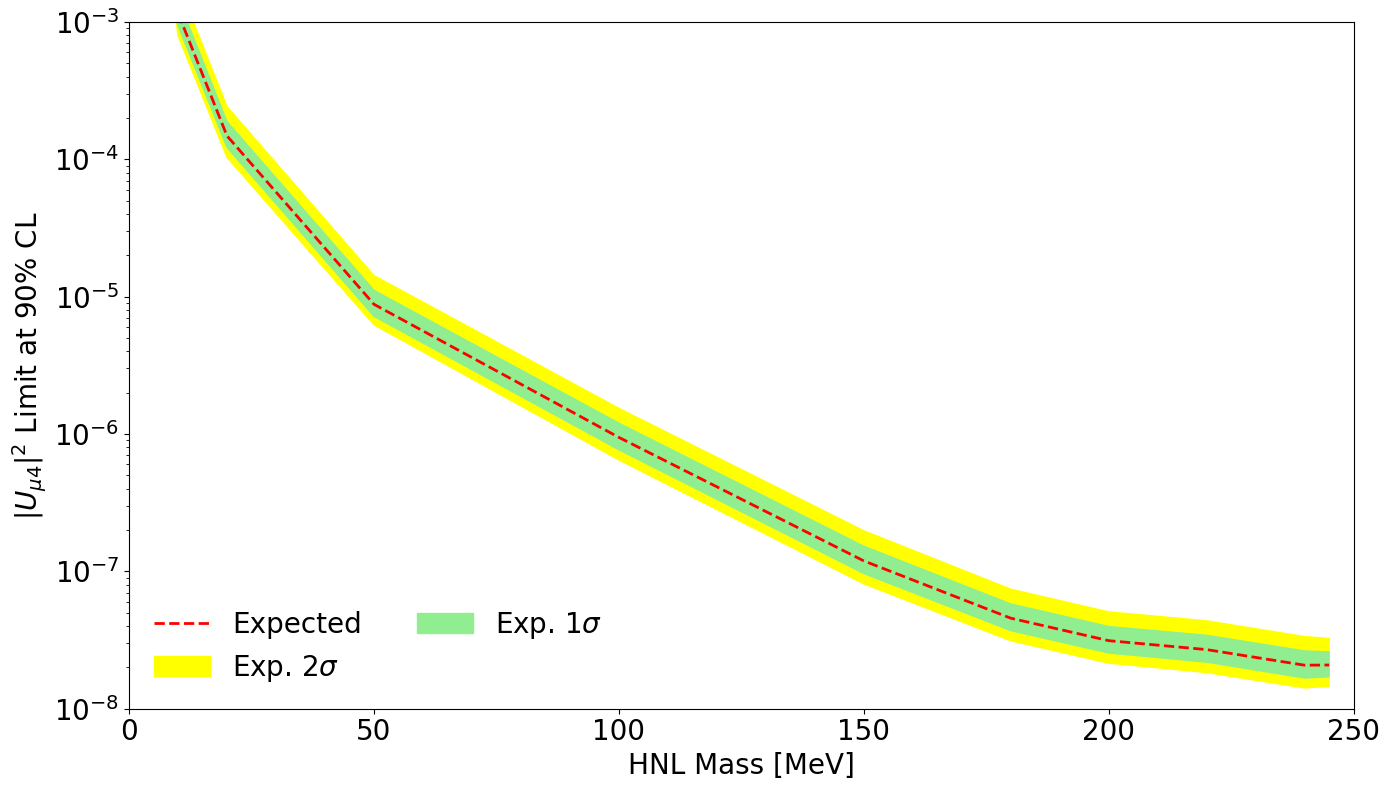

In [30]:
plt.figure(figsize=(14,8),facecolor='white',dpi=100)

savefig = True
# exp_limit = [] #entry 2
# exp_1sig_up = [] #entry 3
# exp_1sig_down = [] #entry 1
# exp_2sig_up = [] #entry 4
# exp_2sig_down = [] #entry 0

# plt.plot(masses_hnl_val,np.sqrt(np.array(obs_limit)),lw=5,ls='-',color='black',label='Observed')
plt.plot(Constants.HNL_mass_samples,np.array(exp_limit),lw=2,ls='--',color='red',label='Expected')
plt.fill_between(Constants.HNL_mass_samples,np.array(exp_2sig_down),np.array(exp_2sig_up),color='yellow',label=r'Exp. 2$\sigma$')
plt.fill_between(Constants.HNL_mass_samples,np.array(exp_1sig_down),np.array(exp_1sig_up),color='lightgreen',label=r'Exp. 1$\sigma$')
# plt.fill_between(masses,m2s,p2s,color='lightgreen',label=r'Exp. 2$\sigma$')
# plt.grid(ls='--',color='C7',alpha=0.1)

plt.ylabel(r'$|U_{\mu 4}|^2$ Limit at 90% CL',fontsize=20)
plt.xlabel('HNL Mass [MeV]',fontsize=20)
# plt.title("HNL Mixing Upper Limit")
plt.ylim(1e-8,1e-3)
plt.legend(loc="lower left",ncol=2,frameon=False,fontsize=20)
# plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlim(0,250)
plt.yscale('log')
plt.tight_layout()

if savefig == True:
    plt.savefig('plots/Limits/Brazil_preliminary.pdf',bbox_inches='tight', pad_inches=0.3)

plt.grid(False)


## End of code

In [20]:
print_vals = input("Do you want to run with new pois? y/n ")
if print_vals == "y":
    poi_new_dict = {}
    for HNL_mass in list_test:
        best_fit_value = exp_limits_dict[HNL_mass][2]
        new_poi_array = np.linspace(0.001, best_fit_value*2, 100)
        poi_new_dict[HNL_mass] = new_poi_array

    obs_limit_dict = {}
    exp_limits_dict = {}
    print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

    # for HNL_mass in Constants.HNL_mass_samples:
    for HNL_mass in list_test:

        obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
            DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_new_dict[HNL_mass], level=0.1, return_results=True
        )

        print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.4f}")
        print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.4f}" + "\n")

Do you want to run with new pois? y/n  y


If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended
Upper limit 2MeV (obs): μ = 0.3651
Upper limit 2MeV (exp): μ = 0.3651

Upper limit 10MeV (obs): μ = 0.2126
Upper limit 10MeV (exp): μ = 0.2126

Upper limit 20MeV (obs): μ = 0.1333
Upper limit 20MeV (exp): μ = 0.1333

Upper limit 50MeV (obs): μ = 0.1187
Upper limit 50MeV (exp): μ = 0.1187

Upper limit 100MeV (obs): μ = 0.8800
Upper limit 100MeV (exp): μ = 0.8800

Upper limit 150MeV (obs): μ = 0.2215
Upper limit 150MeV (exp): μ = 0.2215

Upper limit 180MeV (obs): μ = 1.2810
Upper limit 180MeV (exp): μ = 1.2810

Upper limit 200MeV (obs): μ = 0.6023
Upper limit 200MeV (exp): μ = 0.6023

Upper limit 220MeV (obs): μ = 0.4463
Upper limit 220MeV (exp): μ = 0.4463

Upper limit 240MeV (obs): μ = 0.2637
Upper limit 240MeV (exp): μ = 0.2637

Upper limit 245MeV (obs): μ = 0.2664
Upper limit 245MeV (exp): μ = 0.2664



## Finished code

In [11]:
# def New_BR_limit(Old_theta_squared, HNL_mass):
#     New_limit = Old_theta_squared*np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
#     print("Old limit was " + str(Old_theta_squared))
#     print("New limit is " + str(New_limit))
#     return New_limit

# Old_limits = {20:0.00015681119188699395,
#               50:9.92373190724973e-06,
#               100:9.84200063077575e-07,
#               150:1.2830647341135436e-07,
#               180:7.604092480424186e-08}

In [12]:
# New_limits = []
# for HNL_mass in list_test:
#     New_limits.append(New_BR_limit(Old_limits[HNL_mass], HNL_mass))
    
# r = zip([20,50,100,150,180], New_limits)

# with open(f'limit_files/New_BR_expected_mu.csv', "w") as s:
#     w = csv.writer(s)
#     for row in r:
#         w.writerow(row)

Old limit was 0.00015681119188699395
New limit is 4.473705399878215e-06
Old limit was 9.92373190724973e-06
New limit is 7.026375098105447e-07
Old limit was 9.84200063077575e-07
New limit is 1.3926575446624903e-07
Old limit was 1.2830647341135436e-07
New limit is 2.7234936977555177e-08
Old limit was 7.604092480424186e-08
New limit is 1.935262655698933e-08


In [16]:
# for HNL_mass in Constants.HNL_mass_samples:
#     new_scaling = np.sqrt(1/Constants.Old_gen_HNL_scalings[HNL_mass])
#     print("New scaling is " + str(new_scaling))


New scaling is 0.028529248110697302
New scaling is 0.07080375773727186
New scaling is 0.14150146874688022
New scaling is 0.21226471473687195
New scaling is 0.2545027773769233
New scaling is 0.28289193995533474


In [35]:
print(Total_dict[20]["SIGNAL_ERR_dict"])

#print(Total_dict[20]["SIGNAL_dict"])

[0.050808497914834036, 0.05487945004360595, 0.06145440546673507, 0.06355764988787484, 0.07558287866005854, 0.08151675367339842, 0.09340516893421773, 0.1223239917030607, 0.16126455618691313, 0.3767107403439153, 0.039337891479048835, 0.03850081930059008, 0.04775438903415764, 0.052777319663197715, 0.057503899210725004, 0.06557695378140402, 0.0789857347150117, 0.09886097753972525, 0.14303558448522657, 0.36171050766471524]


In [4]:
TOTAL_SIGNAL_dict = {}
TOTAL_SIGNAL_ERR_dict = {}
TOTAL_BKG_dict = {}
TOTAL_BKG_ERR_dict = {}
TOTAL_DATA_dict = {}

for HNL_mass in HNL_masses:
    
    r1_signal = hist_dict_run1[HNL_mass]['signal']
    r1_EXT = hist_dict_run1[HNL_mass]['bkg_EXT']
    r1_nu = hist_dict_run1[HNL_mass]['bkg_overlay']
    r1_dirt = hist_dict_run1[HNL_mass]['bkg_dirt']
    r1_data = hist_dict_run1[HNL_mass]['data']
    
    r3_signal = hist_dict_run3[HNL_mass]['signal']
    r3_EXT = hist_dict_run3[HNL_mass]['bkg_EXT']
    r3_nu = hist_dict_run3[HNL_mass]['bkg_overlay']
    r3_dirt = hist_dict_run3[HNL_mass]['bkg_dirt']
    r3_data = hist_dict_run3[HNL_mass]['data']
    
    r1_bkg_hists = [r1_EXT, r1_nu, r1_dirt]
    r1_total_bkg = add_hists_vals(r1_bkg_hists)
    
    r3_bkg_hists = [r3_EXT, r3_nu, r3_dirt]
    r3_total_bkg = add_hists_vals(r3_bkg_hists)
    
    if Params_pyhf["Stats_only"] == True:
        overlay_r1_err = get_stat_errors(r1_nu)
        dirt_r1_err = get_stat_errors(r1_dirt)
        
        overlay_r3_err = get_stat_errors(r3_nu)
        dirt_r3_err = get_stat_errors(r3_dirt)
        
        r1_sig_err = get_stat_errors(r1_signal)
        r3_sig_err = get_stat_errors(r3_signal)
        
    elif Params_pyhf["Stats_only"] == False:
        overlay_r1_err = get_full_errors_nu_FLAT_INPUTS(r1_nu)
        dirt_r1_err = get_full_errors_dirt(r1_dirt)
      
        overlay_r3_err = get_full_errors_nu_FLAT_INPUTS(r3_nu)
        dirt_r3_err = get_full_errors_dirt(r3_dirt)
        
        r1_sig_err = get_full_errors_signal(r1_signal)
        r3_sig_err = get_full_errors_signal(r3_signal)
    
    
    r1_bkg_err_list = [overlay_r1_err, r1_EXT.errors(), dirt_r1_err]
    r1_total_bkg_err = add_all_errors(r1_bkg_err_list)

    r3_bkg_err_list = [overlay_r3_err, r3_EXT.errors(), dirt_r3_err]
    r3_total_bkg_err = add_all_errors(r3_bkg_err_list)
    
    #Converting np.ndarrays to lists
    SIGNAL_R1 = np.ndarray.tolist(r1_signal.values())
    SIGNAL_ERR_R1 = np.ndarray.tolist(r1_sig_err)
    BKG_R1 = np.ndarray.tolist(r1_total_bkg)
    BKG_ERR_R1 = np.ndarray.tolist(r1_total_bkg_err)
    DATA_R1 = np.ndarray.tolist(r1_data.values())
    
    SIGNAL_R3 = np.ndarray.tolist(r3_signal.values())
    SIGNAL_ERR_R3 = np.ndarray.tolist(r3_sig_err)
    BKG_R3 = np.ndarray.tolist(r3_total_bkg)
    BKG_ERR_R3 = np.ndarray.tolist(r3_total_bkg_err)
    DATA_R3 = np.ndarray.tolist(r3_data.values())
    
    list_of_lists = [SIGNAL_R1, SIGNAL_ERR_R1, BKG_R1, BKG_ERR_R1, DATA_R1, SIGNAL_R3, SIGNAL_ERR_R3, BKG_R3, BKG_ERR_R3, DATA_R3]
    if Params_pyhf["Use_second_half_only"] == True:
        for n in range(len(list_of_lists)):
            list_of_lists[n]=remove_first_half_hist(list_of_lists[n])
    
    TOTAL_SIGNAL_dict[HNL_mass] = append_r3_to_r1(list_of_lists[0], list_of_lists[5])
    TOTAL_SIGNAL_ERR_dict[HNL_mass] = append_r3_to_r1(list_of_lists[1], list_of_lists[6])
    TOTAL_BKG_dict[HNL_mass] = append_r3_to_r1(list_of_lists[2], list_of_lists[7])
    TOTAL_BKG_ERR_dict[HNL_mass] = append_r3_to_r1(list_of_lists[3], list_of_lists[8])
    TOTAL_DATA_dict[HNL_mass] = append_r3_to_r1(list_of_lists[4], list_of_lists[9])
    
    # print(f"Total {HNL_mass}MeV signal is ")
    # print(SIGNAL_R1)

# print()
# print("Total bkg is ")
# print(r1_total_bkg)

# print()
# print("Total bkg error is  ")
# print(r1_total_bkg_err)

Total 20MeV signal is 
[1.2564858198165894, 0.4351254403591156, 0.44490355253219604, 0.4009020924568176, 0.474237859249115, 0.4546816349029541, 0.48890501260757446, 0.4009020924568176, 0.48401594161987305, 0.4693487882614136, 0.5280174016952515, 0.6160203218460083, 0.7724698781967163, 0.8262494206428528, 1.1684828996658325, 1.3591558933258057, 1.7845032215118408, 3.0605452060699463, 5.319286346435547, 29.026288986206055]
Total 50MeV signal is 
[1.3828301429748535, 0.6708196997642517, 0.5531320571899414, 0.45309752225875854, 0.47075068950653076, 0.6237446665763855, 0.5237101316452026, 0.49428820610046387, 0.7414323091506958, 0.6590509414672852, 0.8591200113296509, 0.6237446665763855, 0.8885419368743896, 1.053304672241211, 1.3592926263809204, 1.7005867958068848, 2.3184471130371094, 3.6895084381103516, 6.060914993286133, 32.0228157043457]
Total 100MeV signal is 
[0.25780484080314636, 0.11260440945625305, 0.1195187121629715, 0.11457992345094681, 0.12939628958702087, 0.12544526159763336, 0.

In [5]:
model_dict = {}
# for HNL_mass in HNL_masses:
#     model_dict[HNL_mass] = pyhf.simplemodels.uncorrelated_background(signal=TOTAL_SIGNAL_dict[HNL_mass],
#                                                                      bkg=TOTAL_BKG_dict[HNL_mass], 
#                                                                      bkg_uncertainty=TOTAL_BKG_ERR_dict[HNL_mass])
    
for HNL_mass in HNL_masses:
    model_dict[HNL_mass] = pyhf.Model(
        {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": TOTAL_SIGNAL_dict[HNL_mass],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": None
            },
            {
              "name": "uncorr_siguncrt",
              "type": "shapesys",
              "data": TOTAL_SIGNAL_ERR_dict[HNL_mass]  
            }
          ]
        },
        {
          "name": "background",
          "data": TOTAL_BKG_dict[HNL_mass],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": TOTAL_BKG_ERR_dict[HNL_mass]
            }
          ]
        }
      ]
    }
  ]
}
)

In [6]:
# model_full = pyhf.model.uncorrelated_background(signal=TOTAL_SIGNAL, signal_uncertainty=TOTAL_SIGNAL_ERR, bkg=TOTAL_BKG, bkg_uncertainty=TOTAL_BKG_ERR)
# model_full
# print(json.dumps(model.spec, indent=2))
# model.config.param_set("uncorr_bkguncrt").n_parameters
#model.config.param_set("uncorr_siguncrt").n_parameters

In [7]:
#print(json.dumps(model.spec, indent=2))
DATA_OBS_dict = {}
for HNL_mass in HNL_masses:
    init_pars = model_dict[HNL_mass].config.suggested_init()
    model_dict[HNL_mass].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[HNL_mass].config.poi_index] = 0
    model_dict[HNL_mass].expected_actualdata(bkg_pars) #bkg only

    DATA_OBS_dict[HNL_mass] = TOTAL_DATA_dict[HNL_mass]+model_dict[HNL_mass].config.auxdata

    model_dict[HNL_mass].logpdf(pars=bkg_pars, data=DATA_OBS_dict[HNL_mass])

In [8]:
#pyhf.infer.mle.fit(data=DATA_OBS, pdf=model)
for HNL_mass in HNL_masses:
    CLs_obs, CLs_exp = pyhf.infer.hypotest(
        1.0,  # null hypothesis
        DATA_OBS_dict[HNL_mass],
        model_dict[HNL_mass],
        test_stat="qtilde",
        return_expected_set=True,
        )
    
#print(f"      Observed CLs: {CLs_obs:.4f}")
    print(f"{HNL_mass}MeV")
    for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
        print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

20MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0000
Expected CLs( 2 σ): 0.0000
50MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0000
Expected CLs( 2 σ): 0.0000
100MeV
Expected CLs(-2 σ): 0.0339
Expected CLs(-1 σ): 0.0954
Expected CLs( 0 σ): 0.2435
Expected CLs( 1 σ): 0.5158
Expected CLs( 2 σ): 0.8163
150MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0011
Expected CLs( 2 σ): 0.0181
180MeV
Expected CLs(-2 σ): 0.0000
Expected CLs(-1 σ): 0.0000
Expected CLs( 0 σ): 0.0000
Expected CLs( 1 σ): 0.0000
Expected CLs( 2 σ): 0.0000
200MeV
Expected CLs(-2 σ): 0.0090
Expected CLs(-1 σ): 0.0354
Expected CLs( 0 σ): 0.1247
Expected CLs( 1 σ): 0.3521
Expected CLs( 2 σ): 0.6948


In [9]:
obs_limit_dict = {}
exp_limits_dict = {}
print("If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended")

for HNL_mass in HNL_masses:

    poi_values = np.linspace(0.001, 10, 100)
    obs_limit_dict[HNL_mass], exp_limits_dict[HNL_mass], (scan, results) = pyhf.infer.intervals.upperlimit(
        DATA_OBS_dict[HNL_mass], model_dict[HNL_mass], poi_values, level=0.1, return_results=True
    )
    print(f"Upper limit {HNL_mass}MeV (obs): μ = {obs_limit_dict[HNL_mass]:.4f}")
    print(f"Upper limit {HNL_mass}MeV (exp): μ = {exp_limits_dict[HNL_mass][2]:.4f}" + "\n")

If the output of the following is equal to the lowest or highest value of poi, the range needs to be extended
Upper limit 20MeV (obs): μ = 0.1928
Upper limit 20MeV (exp): μ = 0.1928

Upper limit 50MeV (obs): μ = 0.1908
Upper limit 50MeV (exp): μ = 0.1908

Upper limit 100MeV (obs): μ = 1.4359
Upper limit 100MeV (exp): μ = 1.4359

Upper limit 150MeV (obs): μ = 0.3653
Upper limit 150MeV (exp): μ = 0.3653

Upper limit 180MeV (obs): μ = 0.0927
Upper limit 180MeV (exp): μ = 0.0927

Upper limit 200MeV (obs): μ = 1.0781
Upper limit 200MeV (exp): μ = 1.0781



In [2]:
with open('bdt_output/new_theta_dict.pkl', 'rb') as handle:
    new_theta_dict = pickle.load(handle)
print(new_theta_dict)

{20: 0.02, 50: 0.005, 100: 0.001, 150: 0.0005, 180: 0.0005, 200: 0.0002}


In [10]:
#Mass point
with open('bdt_output/new_theta_dict.pkl', 'rb') as handle:
    new_theta_dict = pickle.load(handle)
#print(new_theta_dict)
scaled_thetas = new_theta_dict #Saved in 3.5_BDT_Result

exp_limit = []
obs_limit = []

for HNL_mass in HNL_masses:
    theta_squared = (scaled_thetas[HNL_mass])**2

    EXP_LIMIT = np.sqrt(exp_limits_dict[HNL_mass][2])*theta_squared
    LIMIT = np.sqrt(obs_limit_dict[HNL_mass])*theta_squared
    print(f"Expected {HNL_mass}MeV limit is " + str(EXP_LIMIT))
    print(f"Observed {HNL_mass}MeV limit is " + str(LIMIT)+ "\n")
    
    exp_limit.append(EXP_LIMIT)
# print()
# print("Owen's expected limit is " + str(Owen_exp_limit))
# print("Owen's observed limit is " + str(Owen_obs_limit))

# print()
# perc_diff_exp = (1-(EXP_LIMIT/Owen_exp_limit))*100
# perc_diff_obs = (1-(LIMIT/Owen_obs_limit))*100

# print("pyhf expected limit is " + str(perc_diff_exp) + " different from Owen's limit.")
# print("pyhf observed limit is " + str(perc_diff_obs) + " different from Owen's limit.")

Expected 20MeV limit is 0.00017565276611044875
Observed 20MeV limit is 0.00017565277276562592

Expected 50MeV limit is 1.0920525261344537e-05
Observed 50MeV limit is 1.092052522652675e-05

Expected 100MeV limit is 1.1983074147731274e-06
Observed 100MeV limit is 1.1983073726571225e-06

Expected 150MeV limit is 1.510942780087027e-07
Observed 150MeV limit is 1.5109429153975143e-07

Expected 180MeV limit is 7.609925062363602e-08
Observed 180MeV limit is 7.609923365786958e-08

Expected 200MeV limit is 4.153181878369165e-08
Observed 200MeV limit is 4.153181909099249e-08



## Saving Limits as .csv

In [11]:
masses = HNL_masses

if Params_pyhf["Stats_only"] == True:
    stats =  "Stats_only"
else:
    stats = "Owen_sys"
    
if Params_pyhf["Use_second_half_only"] == True:
    half_hist = "havled"
else:
    half_hist = "full_hist"

print(masses)
print(exp_limit)

r = zip(masses, exp_limit)

with open(f'limit_files/{stats}_{half_hist}_expected_mu_COMBINED_highest_E.csv', "w") as s:
    w = csv.writer(s)
    for row in r:
        w.writerow(row)


[20, 50, 100, 150, 180, 200]
[0.00017565276611044875, 1.0920525261344537e-05, 1.1983074147731274e-06, 1.510942780087027e-07, 7.609925062363602e-08, 4.153181878369165e-08]


In [25]:
HNL_mass = 100
print(json.dumps(model_dict[HNL_mass].spec, indent=2))

{
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [
            0.2123590111732483,
            0.11062422394752502,
            0.11753824353218079,
            0.0948207676410675,
            0.08494359999895096,
            0.09975934773683548,
            0.10074706375598907,
            0.09778391569852829,
            0.09778391569852829,
            0.12050139158964157,
            0.1333416998386383,
            0.16099776327610016,
            0.20445728302001953,
            0.21927301585674286,
            0.2508799433708191,
            0.3121183514595032,
            0.43360745906829834,
            0.6222612857818604,
            1.114143967628479,
            4.416079521179199,
            0.11143967509269714,
            0.0829869881272316,
            0.07113170623779297,
            0.06243783235549927,
            0.05137290060520172,
            0.05611501261591911,
            0.0719220

In [ ]:
model_dict_full_sys = {}

for HNL_mass in HNL_masses:
    model_dict_full_sys[HNL_mass] = pyhf.Model(
        {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": TOTAL_SIGNAL_dict[HNL_mass],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": None
            },
            {
              "name": "uncorr_siguncrt",
              "type": "shapesys",
              "data": TOTAL_SIGNAL_ERR_dict[HNL_mass]  
            }
          ]
        },
        {
          "name": "background",
          "data": TOTAL_BKG_dict[HNL_mass],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": TOTAL_BKG_ERR_dict[HNL_mass]
            }
          ]
        }
      ]
    }
  ]
}
)


# Adding in signal systematic uncertainty

In [13]:
#Messing around with model

full_model = pyhf.Model(
    {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [
            0.4354482889175415,
            0.6531724333763123,
            0.9367626905441284,
            1.1947383880615234,
            1.3539148569107056,
            1.192908763885498,
            0.6879351139068604,
            0.2671237289905548,
            0.8156560063362122,
            1.649437665939331,
            2.6418192386627197,
            3.511852264404297,
            3.4166924953460693,
            2.6418192386627197,
            1.114729881286621,
            0.842844545841217
          ],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": None
            },
            {
              "name": "uncorr_siguncrt",
              "type": "shapesys",
              "data": TOTAL_SIGNAL_ERR  
            }
          ]
        },
        {
          "name": "background",
          "data": [
            227.98190307617188,
            185.65267944335938,
            141.53671264648438,
            83.10063171386719,
            39.49835968017578,
            20.065095901489258,
            5.26054573059082,
            0.7651026844978333,
            385.53765869140625,
            330.3393249511719,
            241.39376831054688,
            143.0430908203125,
            55.337371826171875,
            20.656126022338867,
            7.634726524353027,
            3.049088954925537
          ],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": [
                34.158817291259766,
                27.066844940185547,
                22.60236358642578,
                14.79345417022705,
                6.955612659454346,
                4.61644983291626,
                1.6257153749465942,
                0.48608535528182983,
                73.31805419921875,
                65.45207214355469,
                51.50766372680664,
                34.320030212402344,
                10.886519432067871,
                5.264797210693359,
                2.1698012351989746,
                1.1060731410980225
              ]
            }
          ]
        }
      ]
    }
  ]
}
)

In [14]:
#print(json.dumps(full_model.spec, indent=2))
init_pars = full_model.config.suggested_init()
full_model.expected_actualdata(init_pars) #signal plus bkg

bkg_pars = init_pars.copy()
bkg_pars[model.config.poi_index] = 0
full_model.expected_actualdata(bkg_pars) #bkg only

DATA_OBS = TOTAL_DATA+full_model.config.auxdata

full_model.logpdf(pars=bkg_pars, data=DATA_OBS)

array([-111.00315017])

In [15]:
CLs_obs, CLs_exp = pyhf.infer.hypotest(
    1.0,  # null hypothesis
    DATA_OBS,
    full_model,
    test_stat="qtilde",
    return_expected_set=True,
)
print(f"      Observed CLs: {CLs_obs:.4f}")
for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
    print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

      Observed CLs: 0.3368
Expected CLs(-2 σ): 0.1098
Expected CLs(-1 σ): 0.2229
Expected CLs( 0 σ): 0.4195
Expected CLs( 1 σ): 0.6851
Expected CLs( 2 σ): 0.9041


In [16]:
poi_values = np.linspace(0.1, 10, 50)
obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upperlimit(
    DATA_OBS, full_model, poi_values, level=0.1, return_results=True
)
print(f"Upper limit (obs): μ = {obs_limit:.4f}")
print(f"Upper limit (exp): μ = {exp_limits[2]:.4f}")

Upper limit (obs): μ = 1.9852
Upper limit (exp): μ = 2.2352


In [18]:
#Mass point
EXP_LIMIT = np.sqrt(exp_limits[2])*theta_squared
LIMIT = np.sqrt(obs_limit)*theta_squared
print("Expected limit is " + str(EXP_LIMIT))
print("Observed limit is " + str(LIMIT))
print()
print("Owen's expected limit is " + str(Owen_exp_limit))
print("Owen's observed limit is " + str(Owen_obs_limit))

print()
perc_diff_exp = (1-(EXP_LIMIT/Owen_exp_limit))*100
perc_diff_obs = (1-(LIMIT/Owen_obs_limit))*100

# perc_diff_exp = (1-(Owen_exp_limit/EXP_LIMIT))*100
# perc_diff_obs = (1-(Owen_obs_limit/LIMIT))*100

print("pyhf expected limit is " + str(perc_diff_exp) + "% different from Owen's limit.")
print("pyhf observed limit is " + str(perc_diff_obs) + "% different from Owen's limit.")

Expected limit is 1.495059542214373e-08
Observed limit is 1.40898768497879e-08

Owen's expected limit is 1.52039448e-08
Owen's observed limit is 1.46164475e-08

pyhf expected limit is 1.6663397637188937 different from Owen's limit.
pyhf observed limit is 3.6025898236360154 different from Owen's limit.
